# **Week 7 Assignment**: Deploying a Machine Learning Model using Streamlit

In this assignment, we build and deploy a binary classification model using the Titanic dataset. The goal is to predict passenger survival based on features such as age, sex, fare, and class. We will perform data preprocessing, train a model, evaluate its performance, and finally create a user-friendly web app using Streamlit to demonstrate real-time predictions.


### *Step 1: Loading and Inspecting the Titanic Dataset*

In this step, we load the Titanic training dataset using pandas and perform an initial inspection. This includes checking the shape, structure, and a preview of the first few rows to understand the data format and identify potential preprocessing needs.

In [1]:
import pandas as pd

df = pd.read_csv('titanic/train.csv')

print("Shape of the dataset:", df.shape)

print("\nFirst 5 rows of the dataset:")
print(df.head())

print("\nDataset Info:")
print(df.info())

Shape of the dataset: (891, 12)

First 5 rows of the dataset:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123     

### *Step 2: Performing Exploratory Data Analysis (EDA)*

In this step, we will perform a preliminary analysis of the Titanic dataset. We'll explore the distribution of the target variable (`Survived`) and observe patterns across features such as `Sex`, `Pclass`, and `Embarked`. This will help us understand feature importance and detect class imbalances or anomalies.

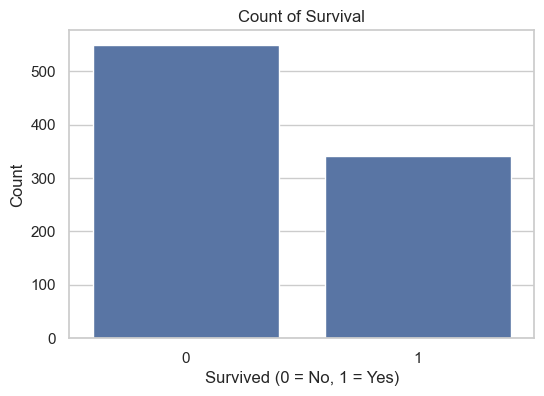

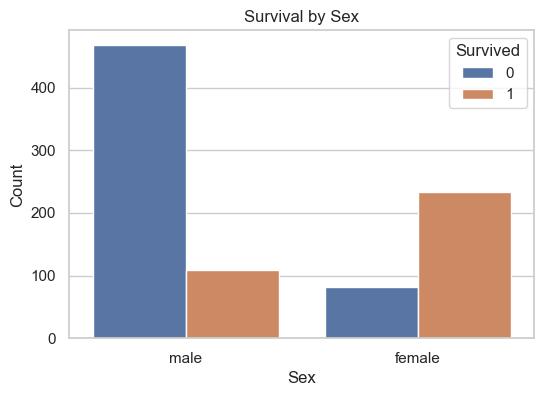

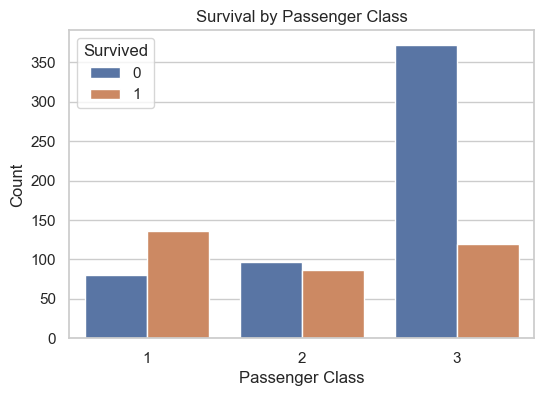

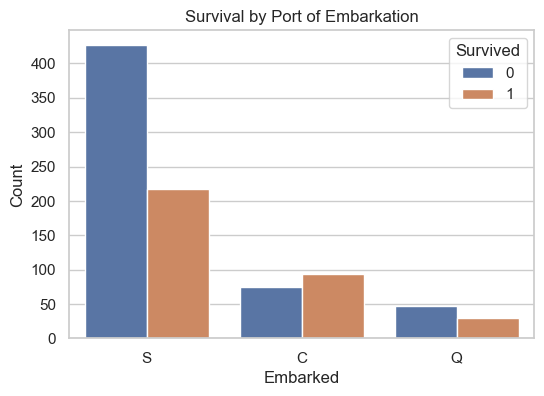

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='whitegrid')

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Survived')
plt.title('Count of Survival')
plt.xlabel('Survived (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Sex', hue='Survived')
plt.title('Survival by Sex')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.legend(title='Survived')
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Pclass', hue='Survived')
plt.title('Survival by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Count')
plt.legend(title='Survived')
plt.show()

# Plot survival count by embarkation port
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='Embarked', hue='Survived')
plt.title('Survival by Port of Embarkation')
plt.xlabel('Embarked')
plt.ylabel('Count')
plt.legend(title='Survived')
plt.show()


### *Step 3: Handling Missing Values and Data Cleaning*

In this step, we will inspect the dataset for missing values and handle them appropriately. We'll impute or drop missing values depending on the nature and importance of the column. This step ensures that the dataset is clean and suitable for machine learning algorithms, which typically do not handle null values well.


In [3]:
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])

Missing values per column:
Age         177
Cabin       687
Embarked      2
dtype: int64


In [4]:
# Age: Fill with median
df['Age'] = df['Age'].fillna(df['Age'].median())

# Embarked: Fill with mode
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# Cabin: Drop (too many missing values)
df.drop(columns='Cabin', inplace=True)

print("\nMissing values after cleaning:")
print(df.isnull().sum()[df.isnull().sum() > 0])


Missing values after cleaning:
Series([], dtype: int64)


### *Step 4: Encoding Categorical Variables*

In this step, we will convert categorical features into numerical form to make them suitable for machine learning algorithms. We will use one-hot encoding to handle features like `Sex`, `Embarked`, and `Pclass`. This transformation allows us to represent categories as binary vectors, preserving information without imposing ordinal relationships.


In [5]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import joblib

# Define features and target
X = df.drop(columns=['Survived', 'Name', 'Ticket', 'PassengerId'])
y = df['Survived']

# Identify categorical and numerical columns
categorical_cols = ['Sex', 'Embarked', 'Pclass']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# Build preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
])

# Fit and transform the training data
X_transformed = preprocessor.fit_transform(X)

# Save encoder and scaler
joblib.dump(preprocessor, 'preprocessor.pkl')


['preprocessor.pkl']

### *Step 5: Feature Selection and Splitting the Dataset*

In this step, we will define the feature set (`X`) and the target variable (`y`). The target is `Survived`, which indicates whether a passenger survived (1) or not (0). We will then split the dataset into training and testing subsets using an 80-20 split. This separation is essential to evaluate the model's performance on unseen data.

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")


Training set size: (712, 9)
Testing set size: (179, 9)


### *Step 6: Training and Evaluating Classification Models*

In this step, we will train multiple classification algorithms including Logistic Regression, Random Forest, and Gradient Boosting. We will evaluate their performance using common classification metrics: **accuracy**, **precision**, **recall**, and **F1-score**. This will help us determine which model performs best on the Titanic dataset.


In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append({
        'Model': name,
        'Accuracy': round(accuracy, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1-Score': round(f1, 4)
    })

results_df = pd.DataFrame(results)
print(results_df)


                 Model  Accuracy  Precision  Recall  F1-Score
0  Logistic Regression    0.7989     0.7794  0.7162    0.7465
1        Random Forest    0.8101     0.7857  0.7432    0.7639
2    Gradient Boosting    0.8156     0.8361  0.6892    0.7556


### *Step 7: Hyperparameter Tuning with GridSearchCV*

In this step, we will apply hyperparameter tuning using `GridSearchCV` to optimize the performance of our classification models. Grid search systematically tries combinations of hyperparameters and selects the best set based on cross-validation performance. We will tune **Random Forest** and **Gradient Boosting**, as they performed best in our initial evaluation.

In [8]:
from sklearn.model_selection import GridSearchCV

# Random Forest Hyperparameters
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Gradient Boosting Hyperparameters
gb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)

print("Tuning Random Forest...")
rf_grid = GridSearchCV(rf, rf_params, cv=5, scoring='f1', n_jobs=-1)
rf_grid.fit(X_train, y_train)

print("Tuning Gradient Boosting...")
gb_grid = GridSearchCV(gb, gb_params, cv=5, scoring='f1', n_jobs=-1)
gb_grid.fit(X_train, y_train)

print("\nBest Random Forest Params:", rf_grid.best_params_)
print("Best Random Forest F1 Score (CV):", round(rf_grid.best_score_, 4))

print("\nBest Gradient Boosting Params:", gb_grid.best_params_)
print("Best Gradient Boosting F1 Score (CV):", round(gb_grid.best_score_, 4))


Tuning Random Forest...
Tuning Gradient Boosting...

Best Random Forest Params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best Random Forest F1 Score (CV): 0.7476

Best Gradient Boosting Params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
Best Gradient Boosting F1 Score (CV): 0.7438


### *Step 8: Final Evaluation on Test Set with Tuned Models*

In this step, we will evaluate the performance of the optimized models (Random Forest and Gradient Boosting) on the test dataset using the best hyperparameters obtained from GridSearchCV. We will compare the metrics — Accuracy, Precision, Recall, and F1-score — with the untuned models to assess improvements.

In [9]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

rf_best = rf_grid.best_estimator_
gb_best = gb_grid.best_estimator_

rf_pred = rf_best.predict(X_test)
gb_pred = gb_best.predict(X_test)

def evaluate_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"\n{name}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    return [name, acc, prec, rec, f1]

results = []
results.append(evaluate_model("Tuned Random Forest", y_test, rf_pred))
results.append(evaluate_model("Tuned Gradient Boosting", y_test, gb_pred))

import pandas as pd
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])
results_df



Tuned Random Forest
Accuracy:  0.8324
Precision: 0.8548
Recall:    0.7162
F1 Score:  0.7794

Tuned Gradient Boosting
Accuracy:  0.8212
Precision: 0.8088
Recall:    0.7432
F1 Score:  0.7746


,Model,Accuracy,Precision,Recall,F1 Score
0,Tuned Random Forest,0.832402,0.854839,0.716216,0.779412
1,Tuned Gradient Boosting,0.821229,0.808824,0.743243,0.774648


### *Step 9: Building a Streamlit Web App for Titanic Survival Prediction*

In this step, we will create an interactive web application using Streamlit to deploy our trained machine learning model. The app will allow users to input passenger features such as age, gender, class, and fare, and it will output the survival prediction based on the model's learned patterns. This step bridges the gap between model development and real-world usability.


In [10]:
import pickle

models = {
    'Random Forest': rf_best,
    'Gradient Boosting': gb_best
}
for name, model in models.items():
    with open(f"{name.replace(' ', '_').lower()}_model.pkl", 'wb') as file:
        pickle.dump(model, file)

print("Models saved successfully.")


Models saved successfully.


### **Conclusion**

In this assignment, we successfully built and deployed a Streamlit web application for predicting Titanic passenger survival using two optimized machine learning models—Random Forest and Gradient Boosting. The project involved comprehensive preprocessing using a `ColumnTransformer`, careful feature engineering, hyperparameter tuning with `GridSearchCV`, and exporting the best models for deployment. 

The interactive app allows users to input passenger details, select a model, and receive predictions with visual probability feedback and interpretability. This exercise provided hands-on experience in the end-to-end lifecycle of a machine learning project, from raw data to a working user-facing web tool.
